# Equipment Failure Data - Data Analysis
#### Author: Bernardo Doré


In this project, we will create a model to predict equipment failures. First we'll fully explore the data we have, check for consistency, run the descriptive statistics and develop some useful visualizations that will help us understand the data and the problem.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [3]:
#READ RAW FILE
file_name = 'filename.xlsx'
file_path = os.path.join(os.getcwd(), 'data', 'raw', file_name)
data = pd.read_excel(file_path)

#### Let's first check for data shape, variable names and overall quality:

In [4]:
data.shape

(800, 10)

Not that many observations. We could be looking at a small sample issue. Let's move on to the variables:

In [5]:
data.columns.to_list()

['Cycle',
 'Preset_1',
 'Preset_2',
 'Temperature',
 'Pressure',
 'VibrationX',
 'VibrationY',
 'VibrationZ',
 'Frequency',
 'Fail']

Judging by the names, this sensor measures motion and the environment of operation.

In [6]:
data.drop_duplicates().shape

(800, 10)

No duplicate rows.

In [7]:
data.isna().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

No missing data. Despite a small sample, data quality looks top notch.

In [8]:
data.describe()

Cycle    Preset_1    Preset_2  Temperature    Pressure  VibrationX  \
count  800.0000  800.000000  800.000000   800.000000  800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   73.860275   
std    231.0844    0.805875    2.293239    25.536252   32.501834   31.229631   
min      1.0000    1.000000    1.000000     2.089354    3.480279    3.846343   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   50.752461   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   69.394953   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   90.195059   
max    800.0000    3.000000    8.000000   255.607829  189.995681  230.861142   

       VibrationY  VibrationZ   Frequency  
count  800.000000  800.000000  800.000000  
mean    72.786878   71.866211   68.223449  
std     32.739745   27.844616   29.138702  
min     10.057744   18.784169    4.380101  
25%     48.523982   50.787638   45.861762  
50%     65.504770   69.319237   65.664252  
75%     94.075572   88.891205   90.097457  
max    193.569947  230.951134  178.090303

### Target Variable Description and Statistics

In [9]:
data['Fail'].dtypes

dtype('bool')

In [10]:
data['Fail'].value_counts()

False    734
True      66
Name: Fail, dtype: int64

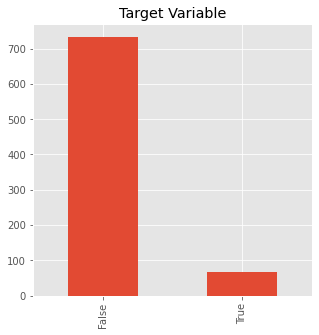

In [11]:
data['Fail'].value_counts().plot.bar(figsize=(5,5), title='Target Variable')
plt.show()

The target variable is boolean. Looks like a binary classification problem. We are also looking at some class imbalance, at a proportion of about 9:1.

The equipment failed 66 times out of 800.

### Discretization of sensor presets
Let's go back to our sensor presets and create some categories for them. They work together so we can just put them together in the same variable.

In [12]:
failed_equip = data[data['Fail'] == True].copy()
failed_equip['Preset_1'] = failed_equip['Preset_1'].astype(str)
failed_equip['Preset_2'] = failed_equip['Preset_2'].astype(str)
failed_equip['Presets_Category'] = failed_equip['Preset_1'] + '_' + failed_equip['Preset_2']
failed_equip['Presets_Category']

12     1_1
156    3_1
157    2_5
158    3_5
162    1_2
      ... 
795    2_6
796    1_4
797    1_4
798    2_8
799    3_1
Name: Presets_Category, Length: 66, dtype: object

### Discretization of parameters
The parameters are numerical values that wouldn't make sense to combine as a string. We can look for the quartiles and then put each one in a bin. We name the bins very high, high, medium, low.

In [13]:
qt_temperature = pd.qcut(failed_equip['Temperature'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
qt_pressure = pd.qcut(failed_equip['Pressure'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
qt_vibrationx = pd.qcut(failed_equip['VibrationX'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
qt_vibrationy = pd.qcut(failed_equip['VibrationY'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
qt_vibrationz = pd.qcut(failed_equip['VibrationZ'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
qt_frequency = pd.qcut(failed_equip['Frequency'].values, 4, retbins=True, labels=['very_high', 'high', 'medium', 'low'])
failed_equip['Temp_quartiles'] = qt_temperature[0]
failed_equip['Press_quartiles'] = qt_pressure[0]
failed_equip['VibX_quartiles'] = qt_vibrationx[0]
failed_equip['VibY_quartiles'] = qt_vibrationy[0]
failed_equip['VibZ_quartiles'] = qt_vibrationz[0]
failed_equip['Freq_quartiles'] = qt_frequency[0]

In [14]:
failed_equip

Cycle Preset_1 Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
12      13        1        1    79.806509  103.129738  120.753103  134.500905   
156    157        3        1    91.695332   85.345796   99.890670   95.328429   
157    158        2        5    88.916114   88.231887   85.140550  123.711911   
158    159        3        5    88.768766   99.228691   89.109514  124.934221   
162    163        1        2   105.969444  110.694610   89.139972  153.575928   
..     ...      ...      ...          ...         ...         ...         ...   
795    796        2        6    50.469522   98.235421  151.585252   99.341380   
796    797        1        4    49.985270  160.433640  110.953010  160.777175   
797    798        1        4    79.777294  110.535405   61.334995  149.577811   
798    799        2        8    79.360314  159.985443   61.762879  169.773831   
799    800        3        1    80.854011  110.543701  121.032227  131.719473   

     VibrationZ   Frequency  Fail Presets_Category Temp_quartiles  \
12   115.873197   76.562856  True              1_1           high   
156  124.970301   84.377355  True              3_1         medium   
157   88.852872  100.229131  True              2_5           high   
158   84.306467   88.218162  True              3_5           high   
162   90.299923  131.072244  True              1_2            low   
..          ...         ...   ...              ...            ...   
795  148.838481   49.841400  True              2_6      very_high   
796  109.917566  110.919290  True              1_4      very_high   
797  129.463843   70.853353  True              1_4      very_high   
798  130.213426   80.113540  True              2_8      very_high   
799   90.331155   71.261717  True              3_1           high   

    Press_quartiles VibX_quartiles VibY_quartiles VibZ_quartiles  \
12             high            low         medium         medium   
156       very_high         medium      very_high            low   
157       very_high      very_high         medium      very_high   
158            high           high         medium      very_high   
162          medium           high            low           high   
..              ...            ...            ...            ...   
795       very_high            low      very_high            low   
796             low         medium            low         medium   
797            high      very_high            low            low   
798             low      very_high            low            low   
799            high            low         medium           high   

    Freq_quartiles  
12       very_high  
156      very_high  
157         medium  
158      very_high  
162            low  
..             ...  
795      very_high  
796            low  
797      very_high  
798      very_high  
799      very_high  

[66 rows x 17 columns]

There it is. The relevant variables are discretized now.

### Exploring the failed equipment

Let's take a deep dive in the failed equipment and see what we find.

In [15]:
failed_equip['Preset_1'].value_counts()

1    27
2    21
3    18
Name: Preset_1, dtype: int64

In [16]:
failed_equip['Preset_2'].value_counts()

5    12
1    11
2     9
6     9
7     9
8     7
3     6
4     3
Name: Preset_2, dtype: int64

Considering the failed cohort, we have more possible values of preset number 2.

In [17]:
failed_equip[['Preset_1', 'Preset_2']].value_counts()

Preset_1  Preset_2
1         2           5
          5           5
          1           4
3         5           4
2         8           4
1         7           4
2         1           4
3         1           3
2         6           3
          5           3
3         6           3
          7           3
1         6           3
2         2           2
1         8           2
2         7           2
1         4           2
3         2           2
          3           2
1         3           2
2         3           2
          4           1
3         8           1
dtype: int64

Since the equipment has configurations that work together, it makes sense to look at them combined.

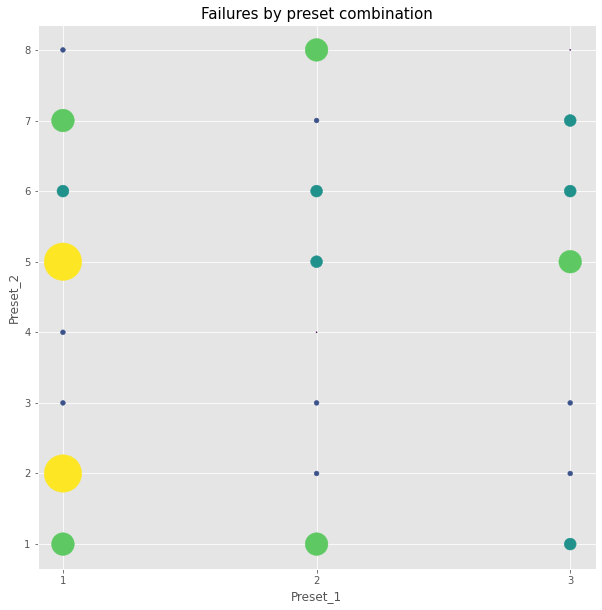

In [18]:
failed_presets = failed_equip[['Preset_1', 'Preset_2', 'Fail']]\
    .groupby(['Preset_1', 'Preset_2'], as_index=False)['Fail']\
    .count()
fp_size = failed_presets[['Fail']] ** 4.5
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(failed_presets['Preset_1'], failed_presets['Preset_2'], s=fp_size, c=failed_presets[['Fail']].values)
ax.set_xlabel('Preset_1')
ax.set_ylabel('Preset_2')
ax.set_title('Failures by preset combination', fontsize=15)
plt.show()

Seems that Preset_1 at 1 combined with Preset_2 at 2 or 5 occurs more often.

We used color and size to better visualize the differences between the combinations. Each failure count has a color and the higher the count, the bigger the dot size.

We are left with 6 parameters to explore. How can we build a visualization for this? The scatter plot gives us 4 properties to work with. Let's think for a bit.

If we consider vibration_X, vibration_Y and vibration_Z as a single variable, we'll be left with 4 variables. The vibration is measured in 3D space so perhaps we can create a new variable to represent the vibration.

In [19]:
data[['VibrationX', 'VibrationY', 'VibrationZ']].describe()

VibrationX  VibrationY  VibrationZ
count  800.000000  800.000000  800.000000
mean    73.860275   72.786878   71.866211
std     31.229631   32.739745   27.844616
min      3.846343   10.057744   18.784169
25%     50.752461   48.523982   50.787638
50%     69.394953   65.504770   69.319237
75%     90.195059   94.075572   88.891205
max    230.861142  193.569947  230.951134

All the vibration parameters have similar mean and standard deviation. The quartiles cutoffs are also close.

We need a scalar to solve our problem. We can solve this by finding the magnitude of the vector with respect to the origin $O$.

In our case, $O = (0, 0, 0)$, so if $V$ is the vibration vector then $|OV|$ is the magnitude:

$|OV| = \sqrt{V_x^2 + V_y^2 + V_z^2} $



In [20]:
def magnitude(v):
    return math.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [21]:
vibration_magnitude = data[['VibrationX', 'VibrationY', 'VibrationZ']].apply(magnitude, axis=1)
vibration_magnitude

0      103.801329
1      130.232621
2      161.994313
3      209.236814
4       90.029176
          ...    
795    234.520131
796    224.146697
797    207.114436
798    222.695629
799    200.395951
Length: 800, dtype: float64

Cool, we got what we need. 

In [22]:
data['Vibration_Magnitude'] = vibration_magnitude
failed_params = data[data['Fail'] == True].copy()
failed_params = failed_params[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Vibration_Magnitude', 'Frequency', 'Fail']]
failed_params.head()

Temperature    Pressure  VibrationX  VibrationY  VibrationZ  \
12     79.806509  103.129738  120.753103  134.500905  115.873197   
156    91.695332   85.345796   99.890670   95.328429  124.970301   
157    88.916114   88.231887   85.140550  123.711911   88.852872   
158    88.768766   99.228691   89.109514  124.934221   84.306467   
162   105.969444  110.694610   89.139972  153.575928   90.299923   

     Vibration_Magnitude   Frequency  Fail  
12            214.705387   76.562856  True  
156           186.234345   84.377355  True  
157           174.494651  100.229131  True  
158           175.090393   88.218162  True  
162           199.212390  131.072244  True

In [23]:
failed_params.describe()

Temperature    Pressure  VibrationX  VibrationY  VibrationZ  \
count    66.000000   66.000000   66.000000   66.000000   66.000000   
mean     92.469125  116.422540  100.167190  122.481159  106.003200   
std      21.683670   30.040055   28.109402   30.861777   28.377486   
min      48.091962   50.822002   20.120467   50.481820   20.522642   
25%      79.784598   98.283167   88.622311   99.473948   89.873117   
50%      90.928964  110.619156   98.043755  122.115118   99.669357   
75%     104.960599  131.353569  118.200618  148.611903  120.635254   
max     150.880308  189.995681  200.749598  193.569947  200.242674   

       Vibration_Magnitude   Frequency  
count            66.000000   66.000000  
mean            195.173744   99.812745  
std              26.435619   22.960578  
min             144.846810   48.923777  
25%             174.241164   89.974024  
50%             190.995984   99.212676  
75%             217.728831  110.702196  
max             255.875406  178.090303

Nice. Let's build our scatter plot:

In [24]:
tv_size = failed_params[['Vibration_Magnitude']].values
tv_rescale = np.interp(tv_size, (tv_size.min(), tv_size.max()), (0, 2000))
plt.figure(figsize=(10,10))
plt.scatter(failed_params['Temperature'], 
            failed_params['Pressure'], 
            s=tv_rescale, 
            c=failed_params[['Frequency']].values,             
            alpha=0.3)
plt.title('Failures by Parameters', size=15)
clt = plt.colorbar()
clt.ax.set_title('Frequency')
plt.plot([70,70], [70, 162], 'b-')
plt.plot([70,112], [162, 162], 'b-')
plt.plot([112,112], [162, 70], 'b-')
plt.plot([70,112], [70, 70], 'b-')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.show()

Each dot is a failure. Dot size is the vibration magnitude. We can see that there is a region of interest, possibly a clusterization. We can define a region for pressure, temperature and frequency based on the scatter plot. But what about the magnitude? We can't quantify it by just looking at the plot.

Let's slice the failures by the region we just found and take the median of the magnitude. We use the median because we have a few small dots in there that could pull down the mean.

In [25]:
failed_params[((failed_params['Temperature'] >= 80) & (failed_params['Temperature'] <= 110) &
              ((failed_params['Pressure'] >= 70) & (failed_params['Pressure'] <= 160)) &
              (failed_params['Frequency'] >= 60) & (failed_params['Frequency'] <= 120))]['Vibration_Magnitude'].median()

186.16853680708766

Great. Approximately, the equipment is more prone to fail when the cycle:
- Temperature ranges from 80 to 110
- Pressure ranges from 70 to 160
- Frequency ranges from 60 to 120
- Vibration magnitude is around 186.

Let's save this to a file, it can be useful later.

In [27]:
data.to_csv(os.path.join(os.getcwd(), 'data', 'processed', 'og_data_processed.csv'), index=False)